# Домашнее задание 3
**Выполнил: Ким Адамейко, группа мАДБМ16**

In [385]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import pubchempy as pcp
import py3Dmol

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem import Draw
import rdkit.Chem.Lipinski as Lip

from IPython.display import display,Image

def show_compound_info(name, from_smiles=False):
    if from_smiles:
        smiles = name
    else:
        pc_compound = pcp.get_compounds(name, 'name')[0]
        smiles = pc_compound.canonical_smiles.encode("ascii")
        print('Compound:   %s\n   IUPAC:   %s\n  SMILES:   %s' % (name, pc_compound.iupac_name, smiles))
    rd_compound = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(rd_compound)
    return rd_compound

## Часть 1. Модификация ибупрофена
Получим с помощью библиотеки `pubchempy` smiles-представление ибупрофена и визуализируем его с помощью библиотеки `rdkit`

Compound:   ibuprofen
   IUPAC:   2-[4-(2-methylpropyl)phenyl]propanoic acid
  SMILES:   CC(C)CC1=CC=C(C=C1)C(C)C(=O)O


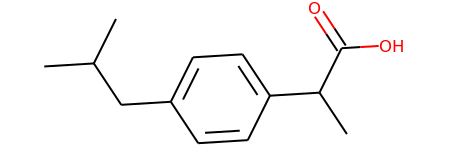

In [68]:
ibuprofen_smiles = pcp.get_compounds('ibuprofen', 'name')[0].canonical_smiles.encode("ascii")
ibuprofen = show_compound_info('ibuprofen')
ibuprofen

Получим также информацию об этине, на который нужно заменить изопропил

Compound:   ethyne
   IUPAC:   acetylene
  SMILES:   C#C


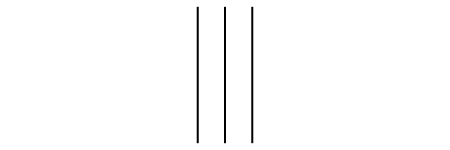

In [55]:
show_compound_info('ethyne')

Самого изопропила в базе нет, но есть изопропиловый спирт

Compound:   isopropyl alcohol
   IUPAC:   propan-2-ol
  SMILES:   CC(C)O


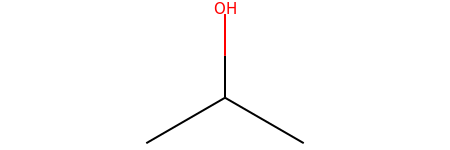

In [56]:
show_compound_info('isopropyl alcohol')

Отсюда, а также IUPAC-имени можно сделать вывод о требуемой замене:

C#CCC1=CC=C(C=C1)C(C)C(=O)O


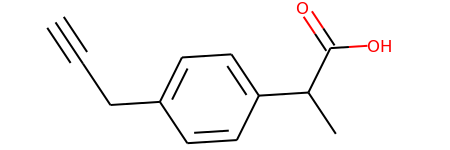

In [84]:
mod_ibuprofen_smiles = ibuprofen_smiles.replace('CC(C)', 'C#C')
print(mod_ibuprofen_smiles)
mod_ibuprofen = Chem.MolFromSmiles(mod_ibuprofen_smiles)
AllChem.Compute2DCoords(mod_ibuprofen)
display(mod_ibuprofen)

## Часть 2. Поиск радикалов с азидом
Википедия сообщает, что азид имеет несколько мезомеров. Я подготовил SMILES-нотации для этих трёх видов с учётом возможного написания в двух "направлениях".
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e8/Organyl_Azide_General_Formulae.png/100px-Organyl_Azide_General_Formulae.png)

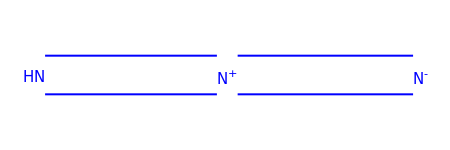

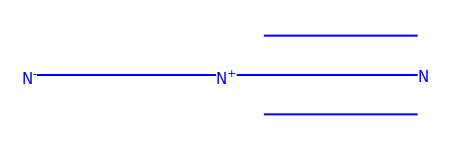

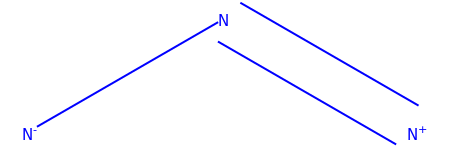

In [159]:
azide_smiles = ['N=[N+]=[N-]', '[N-][N+]#N', '[N-]N=[N+]', '[N-]=[N+]=N', 'N#[N+][N-]', '[N+]=N[N-]']
for a_s in azide_smiles[:3]: # показано только одно "направление" записи, второе -- симметрично
    display(show_compound_info(a_s, from_smiles=True))

Реакция идёт по схеме: $\require{mhchem} \ce{R1-N=N+=N- + R2-C≡C->[Cu]R1-N^{(1)}=N-N-C=C^{(1)}-R2}$

где в качестве $\ce{R2-C≡C}$ будет выступать приведенный выше модифицированный ибупрофен

Что будет присоединено к $R_1$ после реакции (вместо радикала на рисунке автоматически добавлен водород):

N2C=C(N=N2)CC1=CC=C(C=C1)C(C)C(=O)O


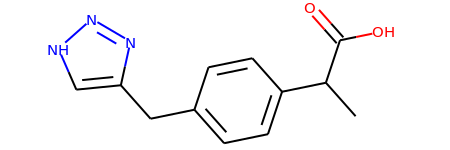

In [113]:
ibuprofen_res_smiles = mod_ibuprofen_smiles.replace('C#C', 'N2C=C(N=N2)')
print(ibuprofen_res_smiles)
ibuprofen_res = Chem.MolFromSmiles(ibuprofen_res_smiles)
AllChem.Compute2DCoords(ibuprofen_res)
display(ibuprofen_res)

Для поиска по базе PubChem уберем из образцов информацию о заряде, получим следующие:

In [163]:
azide_smiles_for_search = set(map(lambda x: re.sub(r'[\[\]\+\-]', '', x), azide_smiles))
azide_smiles_for_search

{'N#NN', 'N=N=N', 'N=NN', 'NN#N', 'NN=N'}

In [169]:
dfs_azides = []
for a_s in azide_smiles_for_search:
    page_no = 0
    results_per_page = 100000
    while True:
        try:
            df_tmp = pcp.get_properties( 
                properties="CanonicalSMILES", namespace="smiles", identifier=a_s, 
                searchtype="substructure", RingsNotEmbedded=True, as_dataframe=True,
                listkey_count=results_per_page, listkey_start=page_no*results_per_page)
            dfs_azides.append(df_tmp)
            page_no += 1
        except:
            break

df_azides = pd.concat(dfs_azides)
del dfs_azides

print('Found %d items' % df_azides.shape[0])    
df_azides.head()

Found 202142 items


CanonicalSMILES
CID                                                     
2354          C1=CC(=CC=C1C(=N)N)NN=NC2=CC=C(C=C2)C(=N)N
1987   CCC1=C(C(=NC(=N1)N)N)C2=CC(=C(C=C2)Cl)N=NN(CCO...
65060  CC(=O)NCC(=O)O.C1=CC(=CC=C1C(=N)N)NN=NC2=CC=C(...
72452  CC[N+]1=C2C=C(C=CC2=C3C=CC(=CC3=C1C4=CC=CC=C4)...
8689                        C1=CC=C(C=C1)NN=NC2=CC=CC=C2

Сразу отбросим вещества, в SMILES нотации которых есть точка, обозначающая нековалентную связь:

In [234]:
df_azides.drop(
    df_azides[df_azides.CanonicalSMILES.str.contains('.', regex=False)].index, 
    inplace=True)      
print('% d items left' % df_azides.shape[0])

 194599 items left


Посчитаем, сколько разных представлений азида встречается в каждой молекуле (будем считать два "симметричных представления одним). Затем сразу удалим строки, где все счётчики нулевые.

In [253]:
for i in range(3):
    df_azides.loc[:,'cnt_a' + str(i)] = \
        df_azides.CanonicalSMILES.str.count(re.escape(azide_smiles[i]) + '|' + re.escape(azide_smiles[i+3])) 
df_azides.head()   

CanonicalSMILES  cnt_a0  cnt_a1  \
CID                                                                        
2354          C1=CC(=CC=C1C(=N)N)NN=NC2=CC=C(C=C2)C(=N)N       0       0   
1987   CCC1=C(C(=NC(=N1)N)N)C2=CC(=C(C=C2)Cl)N=NN(CCO...       0       0   
72452  CC[N+]1=C2C=C(C=CC2=C3C=CC(=CC3=C1C4=CC=CC=C4)...       0       0   
8689                        C1=CC=C(C=C1)NN=NC2=CC=CC=C2       0       0   
72347  CCN1C2=CC(=NN=[N-])C=CC2=[N+](C(=O)C3=C1N=CC=C3)C       0       0   

       cnt_a2  
CID            
2354        0  
1987        0  
72452       0  
8689        0  
72347       0

In [256]:
df_azides.drop(
    df_azides[df_azides.iloc[:, -3:].sum(axis=1) == 0].index,
    inplace=True)      
print('% d items left' % df_azides.shape[0])

 148714 items left


Посчитаем ещё примерное количество атомов путём подсчёта только алфавитных символов в строках

In [257]:
df_azides.loc[:,'atoms_cnt'] = df_azides.CanonicalSMILES.str.count('\w')
df_azides.head()

CanonicalSMILES  cnt_a0  cnt_a1  \
CID                                                                           
57354047  C1=CC(=C(C=C1NN=NCCC2=CNC3=C2C=C(C=C3)O)[N+](=...       1       0   
90258944                            CCC(C(=O)O)NN=[N+]=[N-]       1       0   
353878              CN(CN=[N+]=[N-])N=NC1=CC=C(C=C1)C(=O)OC       1       0   
12367894              CN(C)N=NC1=CC=C(C=C1)C(=O)N=[N+]=[N-]       1       0   
46231168  C(C1C2C(C(C(O1)OC3C(OC(C(C3O)O)OC4C(OC(C(C4O)O...       6       0   

          cnt_a2  atoms_cnt  
CID                          
57354047       0         33  
90258944       0         10  
353878         0         20  
12367894       0         18  
46231168       0        107

Можно построить несколько графиков и таблиц, чтобы оценить разнообразие найденных результатов. Распределение примерного количества атомов:

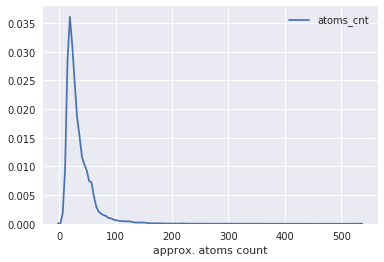

In [283]:
ax = sns.kdeplot(df_azides.atoms_cnt)
ax.set_xlabel('approx. atoms count')
plt.show()

Суммарные значения счётчиков трёх представлений азидов:

In [285]:
df_azides.iloc[:, -4:-1].sum(axis=0)

cnt_a0    148053
cnt_a1     15845
cnt_a2         3
dtype: int64

Видим, что можно пренебречь последним представлением. Как распределяются представления в комбинациях? Видим, что нетривиальные комбинации разных типов встречаются крайне редко, и более 80% комбинаций это единственное в строке появление канонической комбинации  
`N=[N+]=[N-]`.

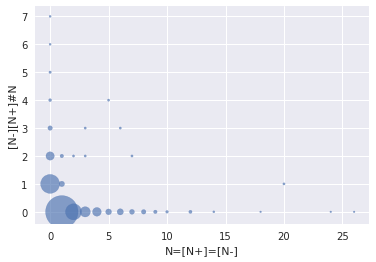

count
cnt_a0 cnt_a1        
0      1        14390
       2          532
       3           44
       4            8
       5            4
       6            2
       7            2
1      0       123920
       1           96
       2           17
2      0         7357
       2            3
3      0         1240
       2            3
       3            3
4      0          642
5      0          125
       4            3
6      0          163
       3            3
7      0           64
       2            3
8      0           47
9      0           17
10     0            6
12     0           12
14     0            2
18     0            1
20     1            3
24     0            1
26     0            1

In [342]:
df_counts = pd.DataFrame(df_azides.groupby(list(df_azides.columns[-4:-2])).size(), columns=['count'])
plt.scatter(*zip(*df_counts.index.tolist()), s=3*np.sqrt(df_counts['count']), alpha=0.66)
plt.xlabel(azide_smiles[0]); plt.ylabel(azide_smiles[1]); 
plt.show()
df_counts

Наконец, применим "правила пяти" Липински 

In [344]:
def Lipinksi_rules(compound):
     return ((Lip.NumHDonors(compound) <= 5)                                # <= 5 hydrogen bond donors
         and (Lip.NumHAcceptors(compound) <= 10)                            # <= 10 hydrogen bond acceptors
         and (Lip.rdMolDescriptors.CalcExactMolWt(compound)<500)            # mol.mass < 500 daltons
         and (Lip.rdMolDescriptors.CalcCrippenDescriptors(compound)[0]<=5)) # octanol-water partit.coeff. logP < 5

In [354]:
azide_full_re = re.compile('|'.join(map(re.escape, azide_smiles)))
df_azides.loc[:, 'resSMILES'] = df_azides.CanonicalSMILES.str.replace(azide_full_re, ibuprofen_res_smiles)

In [362]:
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
results = []
for res_smile in df_azides.resSMILES:
        try:
            compound = Chem.MolFromSmiles(res_smile)
            if Lipinksi_rules(compound):
                results.append(res_smile)
        except:
            pass
print('%d items left after filtering by Lipinski rules' % len(results))

60358 items left after filtering by Lipinski rules


Сохраним результаты:

In [380]:
import pickle
import gzip
with gzip.open('results.pklz', 'wb') as f:
    pickle.dump(results, f)

Отобразим некоторые из них в 2D и в 3D:

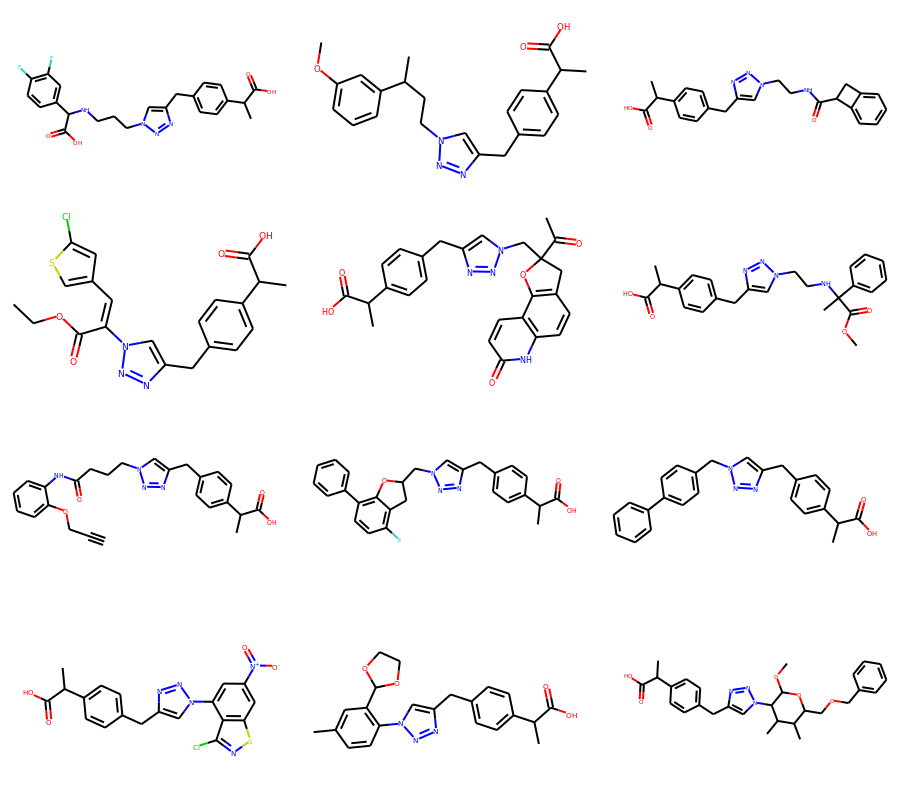

In [365]:
indexes = random.sample(range(len(results)), 12)
images = [Chem.MolFromSmiles(results[i]) for i in indexes]
display(Chem.Draw.MolsToGridImage(images, molsPerRow=3, subImgSize=(300,200)))

К сожалению, у меня пока не получилось заставить работать nglviewer, зато я разобрался, как использовать другую библиотеку -- py3Dmol, которая является обёрткой над известной библиотекой [3Dmol.js](https://github.com/3dmol). Она легко устанавливается с помощью команды `pip install py3Dmol` 

In [480]:
def show_compound_3d(smiles, view, grid=(0, 0)):
    m2d = Chem.MolFromSmiles(smiles)
    m3d = Chem.AddHs(m2d)
    Chem.AllChem.EmbedMolecule(m3d)
    AllChem.MMFFOptimizeMolecule(m3d,maxIters=500,nonBondedThresh=200 )
    mb = Chem.MolToMolBlock(m3d)
    view.addModel(mb,'sdf', viewer=grid)
    view.setStyle({'model':0},{'stick': {}}, viewer=grid)
    view.zoomTo(viewer=grid)
    return view

In [483]:
# view = py3Dmol.view(width=330, height=250)    # образец кода для просмотра одной молекулы
# show_compound_3d(results[0], view)

view = py3Dmol.view(width=320*3, height=250*4, linked=False, viewergrid=(4,3))
for i in range(4):
    for j in range(3):
        show_compound_3d(results[indexes[i*3 + j]], view, grid=(i, j))
view.render()

## Источники
* [Azide - Wikipedia](https://en.wikipedia.org/wiki/Azide)
* [Примеры использования py3Dmol в Jupyter](http://nbviewer.jupyter.org/github/3dmol/3Dmol.js/blob/master/py3Dmol/examples.ipynb)
* [Реализация метода IPythonConsole.drawMol3D()](https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/Draw/IPythonConsole.py), которая почему-то отказывалась работать. Там можно увидеть, как загрузить молекулу в просмотрщик из файла, причём двумя способами -- для больших и малых молекул.
* [Полезный ресурс для отладки регулярных выражений](https://regex101.com/)